In [1]:
import sys, platform
print(sys.version)          # prefer Python 3.11 for best wheel coverage
print(platform.machine())   # should be AMD64 / x86_64


3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
AMD64


In [2]:
#installing packages if not already there
#if present, comment it out

#!pip install openai-whisper
#!pip install pytube
#!pip install ffmpeg-python
#!pip install yt-dlp
#!pip install --upgrade yt-dlp

#in case we already have torch that isn't letting cuda work, uninstall and reinstall and restart kernel
#!pip uninstall torch torchvision torchaudio -y
#!pip install --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu124
#!pip install --pre torch --index-url https://download.pytorch.org/whl/nightly/cu124

In [5]:
#importing packages as necessary
import os
import time
import subprocess
import pandas as pd
import whisper
import yt_dlp
from pathlib import Path
import glob
import random
#import torch


In [ ]:

# ------------------- Config -------------------
os.environ["KEEP_AUDIO"] = "true"
os.environ["AUDIO_DIR"] = r"C:\Users\manor\Downloads\Analysis for Unstructured Data\Final Project\audio"

PLAYLIST_URL  = os.getenv("PLAYLIST_URL", "https://youtube.com/playlist?list=PLdCPA32W_p39Z8hi7xSIX3Fkqmhd7mRzj&si=1NuXOm3x_FauXwSH")
MAX_VIDEOS    = int(os.getenv("MAX_VIDEOS", "56"))
START_FROM_VIDEO = int(os.getenv("START_FROM_VIDEO", "44"))  #Resume from where you left off
API_KEY       = os.getenv("YOUTUBE_API_KEY_PLACEHOLDER", "").strip()
USE_YT_API    = bool(API_KEY)

WHISPER_MODEL = os.getenv("WHISPER_MODEL", "small")
WHISPER_LANG  = os.getenv("WHISPER_LANG", "en")
AUDIO_DIR     = os.getenv("AUDIO_DIR", "audio_temp")
KEEP_AUDIO    = os.getenv("KEEP_AUDIO", "false").lower() == "true"

OUT_DIR       = os.getenv("OUT_DIR", "data")
OUT_FILE      = os.path.join(OUT_DIR, "playlist_transcripts_whisper.csv")
TRANSCRIPT_DIR = r"C:\Users\manor\Downloads\Analysis for Unstructured Data\Final Project\transcript"

FFMPEG_LOCATION = os.getenv("FFMPEG_LOCATION", "").strip() or None
if FFMPEG_LOCATION and FFMPEG_LOCATION not in os.environ.get("PATH", ""):
    os.environ["PATH"] = FFMPEG_LOCATION + os.pathsep + os.environ.get("PATH", "")

# ------------------- Small utilities -------------------

def _check_ffmpeg():
    """Return True if ffmpeg is callable; else False."""
    try:
        subprocess.run(["ffmpeg", "-version"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False)
        subprocess.run(["ffprobe", "-version"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False)
        return True
    except Exception:
        return False

def playlist_id_from_url(url: str) -> str:
    import urllib.parse as up
    q = up.urlparse(url).query
    d = dict(up.parse_qsl(q))
    return d.get("list")

def get_playlist_video_ids(youtube, playlist_id, max_videos=50):
    ids, nextPageToken = [], None
    while len(ids) < max_videos:
        req = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults=min(50, max_videos - len(ids)),
            pageToken=nextPageToken
        )
        res = req.execute()
        ids.extend([it["contentDetails"]["videoId"] for it in res.get("items", [])])
        nextPageToken = res.get("nextPageToken")
        if not nextPageToken:
            break
    return ids[:max_videos]

def get_video_metadata(youtube, video_ids):
    rows = []
    for i in range(0, len(video_ids), 50):
        chunk = video_ids[i:i+50]
        res = youtube.videos().list(
            part="snippet,statistics,contentDetails",
            id=",".join(chunk)
        ).execute()
        for v in res.get("items", []):
            sn = v.get("snippet", {})
            st = v.get("statistics", {})
            cd = v.get("contentDetails", {})
            rows.append({
                "video_id": v.get("id"),
                "title": sn.get("title"),
                "description": sn.get("description"),
                "publishedAt": sn.get("publishedAt"),
                "channelId": sn.get("channelId"),
                "channelTitle": sn.get("channelTitle"),
                "duration": cd.get("duration"),
                "viewCount": int(st.get("viewCount", 0)) if "viewCount" in st else None,
                "likeCount": int(st.get("likeCount", 0)) if "likeCount" in st else None,
                "commentCount": int(st.get("commentCount", 0)) if "commentCount" in st else None,
                "tags": "|".join(sn.get("tags", [])) if sn.get("tags") else None
            })
    return pd.DataFrame(rows)

def get_playlist_items_with_ytdlp(playlist_url, max_videos=50):
    ydl_opts = {"quiet": True, "extract_flat": True, "dump_single_json": True}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(playlist_url, download=False)
    entries = (info or {}).get("entries", [])[:max_videos]
    rows = []
    for e in entries:
        rows.append({
            "video_id": e.get("id"),
            "title": e.get("title"),
            "description": None,
            "publishedAt": e.get("upload_date"),
            "channelId": None,
            "channelTitle": info.get("uploader"),
            "duration": e.get("duration"),
            "viewCount": None, "likeCount": None, "commentCount": None,
            "tags": None
        })
    df = pd.DataFrame([r for r in rows if r["video_id"]])
    vids = [r["video_id"] for r in rows if r["video_id"]]
    return vids, df

def download_audio_ytdlp(video_id, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    video_url = f"https://www.youtube.com/watch?v={video_id}"

    ydl_opts = {
        "format": "bestaudio[ext=m4a]/bestaudio/best",
        "outtmpl": os.path.join(output_dir, f"{video_id}.%(ext)s"),
        "quiet": True,
        "no_warnings": True,
        "postprocessors": [{
            "key": "FFmpegExtractAudio",
            "preferredcodec": "m4a",
            "preferredquality": "192",
        }],
        # Just the simple player client workaround - no cookies
        "extractor_args": {
            "youtube": {
                "player_client": ["android", "web"],
                "player_skip": ["webpage"],
            }
        },
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(video_url, download=True)
            if not info:
                return None
            
            base = os.path.join(output_dir, video_id)
            for ext in ("m4a", "mp3", "webm", "opus"):
                cand = f"{base}.{ext}"
                if os.path.exists(cand):
                    return cand
            
            hits = glob.glob(base + ".*")
            return hits[0] if hits else None
            
    except Exception as e:
        print(f"  Download error: {str(e)[:100]}")
        return None

def transcribe_with_whisper(video_id, model):
    audio_file = download_audio_ytdlp(video_id, AUDIO_DIR)
    if not audio_file or not os.path.exists(audio_file):
        return None, "download_failed", 0.0
    
    # Check if audio file is valid (has content)
    if os.path.getsize(audio_file) < 1000:  # Less than 1KB = corrupted
        print(f"  Warning: Audio file too small, likely corrupted")
        if os.path.exists(audio_file):
            os.remove(audio_file)
        return None, "corrupted_audio", 0.0
    
    t0 = time.time()
    try:
        result = model.transcribe(audio_file, language=WHISPER_LANG, verbose=False, fp16=False)
    except Exception as e:
        print(f"  Transcription error: {str(e)[:100]}")
        # Delete corrupted file
        if os.path.exists(audio_file):
            os.remove(audio_file)
        return None, "transcription_error", 0.0
    
    dt = time.time() - t0
    txt = (result.get("text") or "").strip()
    if not txt or len(txt) < 10:
        if not KEEP_AUDIO and os.path.exists(audio_file):
            os.remove(audio_file)
        return None, "empty_transcript", dt
    if not KEEP_AUDIO and os.path.exists(audio_file):
        os.remove(audio_file)
    return txt, "success_whisper", dt

def basic_clean(s):
    import re
    if not isinstance(s, str):
        return s
    s = s.replace("\n", " ").strip()
    return re.sub(r"\s+", " ", s)

def safe_title(meta_df, vid):
    m = meta_df.loc[meta_df["video_id"] == vid, "title"]
    return m.iloc[0] if len(m) else f"(untitled {vid})"

def save_transcript_file(video_id, transcript_text):
    """Save transcript as a text file."""
    if transcript_text:
        os.makedirs(TRANSCRIPT_DIR, exist_ok=True)
        transcript_path = os.path.join(TRANSCRIPT_DIR, f"{video_id}.txt")
        with open(transcript_path, 'w', encoding='utf-8') as f:
            f.write(transcript_text)

def load_existing_transcript(video_id):
    """Load transcript from existing file if it exists."""
    transcript_path = os.path.join(TRANSCRIPT_DIR, f"{video_id}.txt")
    if os.path.exists(transcript_path):
        try:
            with open(transcript_path, 'r', encoding='utf-8') as f:
                return f.read()
        except Exception:
            return None
    return None

# ------------------- Run -------------------
print("=" * 70)
print("YouTube Playlist Transcription with Whisper (yt-dlp first)")
print("=" * 70)
print(f"Playlist: {PLAYLIST_URL}")
print(f"Max videos: {MAX_VIDEOS}")
print(f"Starting from video: {START_FROM_VIDEO}")
print(f"Whisper model: {WHISPER_MODEL}, lang={WHISPER_LANG}")
print(f"Keep audio files: {KEEP_AUDIO}")
print()

if not _check_ffmpeg():
    print("✗ ERROR: ffmpeg/ffprobe not found.")
    raise SystemExit(1)

# Acquire IDs + metadata
if USE_YT_API:
    print("Mode: YouTube Data API + yt-dlp")
    from googleapiclient.discovery import build
    youtube = build("youtube", "v3", developerKey=API_KEY)
    pid = playlist_id_from_url(PLAYLIST_URL)
    video_ids = get_playlist_video_ids(youtube, pid, max_videos=MAX_VIDEOS)
    print(f"✓ Found {len(video_ids)} videos")
    meta_df = get_video_metadata(youtube, video_ids)
else:
    print("Mode: yt-dlp only (no API quota)")
    video_ids, meta_df = get_playlist_items_with_ytdlp(PLAYLIST_URL, max_videos=MAX_VIDEOS)
    print(f"✓ Found {len(video_ids)} videos via yt-dlp")

missing_meta = set(video_ids) - set(meta_df.get("video_id", []))
if missing_meta:
    meta_df = pd.concat(
        [meta_df, pd.DataFrame({"video_id": list(missing_meta)})],
        ignore_index=True
    )

# Load Whisper
print(f"\nLoading Whisper '{WHISPER_MODEL}'...")
whisper_model = whisper.load_model(WHISPER_MODEL)
print("✓ Whisper model loaded")

# Transcribe
print("\n" + "=" * 70)
print(f"Transcribing videos {START_FROM_VIDEO} to {len(video_ids)}…")
print("=" * 70 + "\n")

tx_rows, status_counts = [], {}
order_map = {vid: i+1 for i, vid in enumerate(video_ids)}
t_total0 = time.time()

for i, vid in enumerate(video_ids, 1):
    # Skip videos before START_FROM_VIDEO
    if i < START_FROM_VIDEO:
        # Load existing transcript for CSV
        existing_txt = load_existing_transcript(vid)
        if existing_txt:
            tx_rows.append({
                "video_id": vid,
                "transcript_whisper": existing_txt,
                "transcript_status": "loaded_from_file",
                "transcription_time_sec": 0.0
            })
            status_counts["loaded_from_file"] = status_counts.get("loaded_from_file", 0) + 1
        continue
    
    title = safe_title(meta_df, vid)
    
    # Check if already processed
    existing_txt = load_existing_transcript(vid)
    if existing_txt:
        print(f"[{i}/{len(video_ids)}] {title[:60]}… ⏭️ SKIPPED (already exists)")
        tx_rows.append({
            "video_id": vid,
            "transcript_whisper": existing_txt,
            "transcript_status": "loaded_from_file",
            "transcription_time_sec": 0.0
        })
        status_counts["loaded_from_file"] = status_counts.get("loaded_from_file", 0) + 1
        continue
    
    # Add delay to avoid bot detection (skip for first new video)
    if i > START_FROM_VIDEO:
        delay = random.uniform(5, 10)
        print(f"[{i}/{len(video_ids)}] Waiting {delay:.1f}s to avoid bot detection...")
        time.sleep(delay)
    
    print(f"[{i}/{len(video_ids)}] {title[:60]}…")
    txt, status, dt = transcribe_with_whisper(vid, whisper_model)

    if txt:
        save_transcript_file(vid, txt)
    
    tx_rows.append({
        "video_id": vid,
        "transcript_whisper": txt,
        "transcript_status": status,
        "transcription_time_sec": round(dt, 2)
    })
    status_counts[status] = status_counts.get(status, 0) + 1
    
    if status == "success_whisper":
        print(f"  ✓ {dt:.1f}s | {len(txt)} chars")
    else:
        print(f"  ✗ {status}")
    print()

elapsed = time.time() - t_total0

tx_df = pd.DataFrame(tx_rows)
dataset = meta_df.merge(tx_df, on="video_id", how="left")

# Clean + snapshot columns
dataset["title"] = dataset["title"].map(basic_clean)
dataset["description"] = dataset["description"].map(basic_clean)
dataset["transcript_whisper"] = dataset["transcript_whisper"].map(basic_clean)
dataset["playlist_url"] = PLAYLIST_URL
dataset["run_ts_utc"] = pd.Timestamp.utcnow().isoformat()
dataset["order_in_playlist"] = dataset["video_id"].map(order_map)

# Save
os.makedirs(OUT_DIR, exist_ok=True)
dataset.to_csv(OUT_FILE, index=False)

# Summary
print("=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"✓ Saved {OUT_FILE}")
print(f"Total videos: {len(dataset)}")
ok_count = status_counts.get("success_whisper", 0) + status_counts.get("loaded_from_file", 0)
print(f"Successful: {ok_count}")
print(f"Failed: {len(dataset) - ok_count}")

print("\nStatus breakdown:")
for k, v in sorted(status_counts.items(), key=lambda x: -x[1]):
    print(f"  {k}: {v}")

succ = dataset[dataset["transcript_status"].isin(["success_whisper", "loaded_from_file"])]
if len(succ) > 0:
    s = succ.iloc[0]
    preview = str(s["transcript_whisper"])[:300]
    print("\nSample (first success):")
    print(f"  Title: {s.get('title')}")
    print(f"  Transcript length: {len(str(s['transcript_whisper']))} chars")
    print(f"  Preview: {preview}...")

print(f"\nTotal processing time: {elapsed/60:.1f} minutes")
print("=" * 70)


YouTube Playlist Transcription with Whisper (yt-dlp first)
Playlist: https://youtube.com/playlist?list=PLdCPA32W_p39Z8hi7xSIX3Fkqmhd7mRzj&si=1NuXOm3x_FauXwSH
Max videos: 56
Starting from video: 44
Whisper model: small, lang=en
Keep audio files: True

Mode: yt-dlp only (no API quota)


✓ Found 56 videos via yt-dlp

Loading Whisper 'small'...
✓ Whisper model loaded

Transcribing videos 44 to 56…

[44/56] Recovery - Ricardo Bustos-The Son's Story…
                                                           

100%|███████████████████████████████████████████████████████████████████████| 57966/57966 [02:46<00:00, 347.78frames/s]


  ✓ 170.1s | 7336 chars

[45/56] Waiting 5.4s to avoid bot detection...
[45/56] FENTANYL KILLS - Brad Bishop - My Brother's Keeper - episode…
                                                           

100%|█████████████████████████████████████████████████████████████████████| 185508/185508 [07:43<00:00, 400.33frames/s]


  ✓ 470.4s | 19909 chars

[46/56] Waiting 7.9s to avoid bot detection...
[46/56] FENTANYL KILLS - Heather Koper - My Brother's Keeper - episo…
                                                           

 99%|████████████████████████████████████████████████████████████████████▌| 322016/324129 [15:43<00:06, 341.33frames/s]


  ✓ 955.6s | 37540 chars

[47/56] Waiting 8.0s to avoid bot detection...
[47/56] FENTANYL KILLS - Rudy Koper - My Brother's Keeper - episode …
                                                           

100%|█████████████████████████████████████████████████████████████████████| 299340/299340 [15:56<00:00, 312.87frames/s]


  ✓ 964.6s | 41060 chars

[48/56] Waiting 8.4s to avoid bot detection...
[48/56] FENTANYL - RECOVERY "Just ask for help" - episode 258…
                                                           

 98%|█████████████████████████████████████████████████████████████████████▏ | 84996/87156 [04:25<00:06, 319.61frames/s]


  ✓ 268.2s | 9614 chars

[49/56] Waiting 9.7s to avoid bot detection...
[49/56] Recovery - Lesson Learned-Ashley Hughes' Story…
                                                           

100%|███████████████████████████████████████████████████████████████████████| 88895/88895 [04:51<00:00, 304.70frames/s]


  ✓ 293.4s | 11327 chars

[50/56] Waiting 8.7s to avoid bot detection...
[50/56] CANNABIS INDUCED PSYCHOSIS - Kobe's Story, ep.6…
                                                           

100%|█████████████████████████████████████████████████████████████████████| 199468/199468 [10:37<00:00, 312.84frames/s]


  ✓ 646.2s | 27468 chars

[51/56] Waiting 9.6s to avoid bot detection...
[51/56] CANNABIS INDUCED PSYCHOSIS - Addiction, Cannabis and the Bra…
                                                           

 98%|█████████████████████████████████████████████████████████████████████▋ | 91820/93604 [04:54<00:05, 312.23frames/s]


  ✓ 296.0s | 11621 chars

[52/56] Waiting 5.6s to avoid bot detection...
[52/56] CANNABIS INDUCED PSYCHOSIS - Seth Juris' Story, ep.8…
                                                           

 98%|█████████████████████████████████████████████████████████████████████▉ | 94112/95554 [05:19<00:04, 294.23frames/s]


  ✓ 321.8s | 12211 chars

[53/56] Waiting 8.8s to avoid bot detection...
[53/56] THE JOURNEY From Addiction to Recovery - Chad Hughes…
                                                         

 98%|█████████████████████████████████████████████████████████████████████▌ | 77436/79063 [03:06<00:03, 416.17frames/s]


  ✓ 189.0s | 8368 chars

[54/56] Waiting 9.7s to avoid bot detection...
[54/56] THE JOURNEY From Addiction to Recovery - Just start where yo…
                                                           

100%|█████████████████████████████████████████████████████████████████████| 125747/125747 [06:11<00:00, 338.36frames/s]


  ✓ 375.2s | 16483 chars

[55/56] Waiting 5.7s to avoid bot detection...
[55/56] FENTANYL KILLS - Losing Five - episode 287…
                                                           

 94%|██████████████████████████████████████████████████████████████████▍    | 89208/95271 [03:58<00:16, 374.23frames/s]


  ✓ 243.2s | 8411 chars

[56/56] Waiting 6.3s to avoid bot detection...
[56/56] DOMESTIC VIOLENCE - UNBROKEN…
                                                           

 96%|████████████████████████████████████████████████████████████████████▏  | 73837/76837 [03:20<00:08, 368.21frames/s]


  ✓ 204.7s | 9151 chars

SUMMARY
✓ Saved data\playlist_transcripts_whisper.csv
Total videos: 56
Successful: 51
Failed: 5

Status breakdown:
  loaded_from_file: 38
  success_whisper: 13

Sample (first success):
  Title: Mike's Story - The Fires of Recovery
  Transcript length: 6081 chars
  Preview: I'm here because I want to make a difference. I can't say that I've ever used fentanyl, but heroin was my addiction, and I've been in recovery for seven years. What would you say to someone who's just starting out in recovery? In recovery, I would tell them, don't give up before the miracle happens....

Total processing time: 94.9 minutes


In [16]:
import os
import pandas as pd
import glob
import yt_dlp

TRANSCRIPT_DIR = r"C:\Users\manor\Downloads\Analysis for Unstructured Data\Final Project\transcript"
PLAYLIST_URL = "https://youtube.com/playlist?list=PLdCPA32W_p39Z8hi7xSIX3Fkqmhd7mRzj&si=1NuXOm3x_FauXwSH"
OUT_DIR = "data"
OUT_FILE = os.path.join(OUT_DIR, "playlist_transcripts_complete.csv")

# Step 1: Get playlist metadata
print("Fetching playlist metadata...")
ydl_opts = {"quiet": True, "extract_flat": True, "dump_single_json": True}
try:
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(PLAYLIST_URL, download=False)
    entries = info.get("entries", [])
    meta_df = pd.DataFrame([{
        "video_id": e.get("id"),
        "title": e.get("title"),
        "duration": e.get("duration"),
        "order_in_playlist": i+1
    } for i, e in enumerate(entries) if e.get("id")])
    print(f"✓ Found {len(meta_df)} videos in playlist")
except Exception as e:
    print(f"⚠️ Could not fetch playlist metadata: {e}")
    meta_df = pd.DataFrame()

# Step 2: Get ALL transcript files
transcript_files = glob.glob(os.path.join(TRANSCRIPT_DIR, "*.txt"))
print(f"✓ Found {len(transcript_files)} transcript files")

# Step 3: Load all transcripts
transcript_data = []
for i, txt_file in enumerate(transcript_files, 1):
    video_id = os.path.splitext(os.path.basename(txt_file))[0]
    with open(txt_file, 'r', encoding='utf-8') as f:
        transcript = f.read()
    
    transcript_data.append({
        "video_id": video_id,
        "transcript_whisper": transcript,
        "transcript_status": "loaded_from_file",
        "transcript_length": len(transcript)
    })
    print(f"  [{i}/{len(transcript_files)}] Loaded {video_id} ({len(transcript)} chars)")

transcript_df = pd.DataFrame(transcript_data)

# Step 4: Merge, keeping ALL transcripts even if not in playlist metadata
if len(meta_df) > 0:
    # Left join from transcripts (keep all transcripts)
    dataset = transcript_df.merge(meta_df, on="video_id", how="left")
    
    # Fill missing metadata
    dataset["title"] = dataset["title"].fillna("(unknown - video may be hidden/deleted)")
    dataset["duration"] = dataset["duration"].fillna(0)
    dataset["order_in_playlist"] = dataset["order_in_playlist"].fillna(999)
    
    missing_from_playlist = dataset[dataset["title"].str.contains("unknown", na=False)]
    if len(missing_from_playlist) > 0:
        print(f"\n⚠️ {len(missing_from_playlist)} transcripts have no metadata (hidden/deleted videos):")
        for vid in missing_from_playlist["video_id"]:
            print(f"  - {vid}")
else:
    # No metadata available, use transcripts only
    dataset = transcript_df.copy()
    dataset["title"] = "(metadata unavailable)"
    dataset["duration"] = None
    dataset["order_in_playlist"] = range(1, len(dataset) + 1)

# Add standard columns
dataset["playlist_url"] = PLAYLIST_URL
dataset["run_ts_utc"] = pd.Timestamp.utcnow().isoformat()

# Save
os.makedirs(OUT_DIR, exist_ok=True)
dataset.to_csv(OUT_FILE, index=False)

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"✅ CSV created: {OUT_FILE}")
print(f"Total transcripts: {len(dataset)}")
print(f"With metadata: {dataset['title'].notna().sum() - len(dataset[dataset['title'].str.contains('unknown', na=False)])}")
print(f"Without metadata (hidden/deleted): {len(dataset[dataset['title'].str.contains('unknown', na=False)])}")
print(f"Average transcript length: {dataset['transcript_length'].mean():.0f} chars")
print("="*70)

Fetching playlist metadata...


✓ Found 56 videos in playlist
✓ Found 51 transcript files
  [1/51] Loaded -GhhcZUYmMk (15815 chars)
  [2/51] Loaded 0W6KDKYWnyg (8755 chars)
  [3/51] Loaded 1Qd-N-VGOjE (13180 chars)
  [4/51] Loaded 3KsgiMRp_v4 (15737 chars)
  [5/51] Loaded 4K1Sz0vcJEI (6081 chars)
  [6/51] Loaded 5b92hK8P1OA (4908 chars)
  [7/51] Loaded 5R9j4JjQANE (8019 chars)
  [8/51] Loaded 5WomfsgXMJg (18099 chars)
  [9/51] Loaded 6cvmIM0kOh8 (9814 chars)
  [10/51] Loaded 9M_5d_-VanY (14853 chars)
  [11/51] Loaded 9VfUnZ-uxTs (14871 chars)
  [12/51] Loaded avwelLFOUKk (17973 chars)
  [13/51] Loaded bXWDHI1vro8 (8832 chars)
  [14/51] Loaded cSEjTH120Zw (8411 chars)
  [15/51] Loaded cTgUyxT7M9s (7109 chars)
  [16/51] Loaded Ed2gb2yoG80 (27672 chars)
  [17/51] Loaded f9tV6TCmv3w (27842 chars)
  [18/51] Loaded ggvveOo6_QU (7336 chars)
  [19/51] Loaded hlbQUDdZaOE (13580 chars)
  [20/51] Loaded jpTkDrHNuNA (5379 chars)
  [21/51] Loaded KQsotPbJ2mw (11327 chars)
  [22/51] Loaded L-aAo5HvPrY (19909 chars)
  [23/51] Loade

In [20]:
df = pd.read_csv(r"data\playlist_transcripts_complete.csv")

In [21]:
df.shape

(51, 9)

In [42]:
"""
Recovery Story Profiling: Stage Detection & Severity Analysis
-------------------------------------------------------------
Analyzes retrospective recovery narratives to identify:
- Which recovery stages are mentioned
- How much emphasis each stage receives
- Severity of consequences and losses
- Common patterns in recovery experiences
"""

import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== CONFIGURATION ====================
TEXT_COL = "transcript_whisper"
USE_SENTIMENT = True
CHUNK_SIZE = 5  # sentences per segment

# ==================== SENTIMENT SETUP ====================
if USE_SENTIMENT:
    import nltk
    try:
        nltk.data.find('vader_lexicon')
    except LookupError:
        nltk.download("vader_lexicon", quiet=True)
    from nltk.sentiment import SentimentIntensityAnalyzer
    SIA = SentimentIntensityAnalyzer()
    
    def sentiment(text: str) -> float:
        return SIA.polarity_scores(str(text))["compound"]
else:
    def sentiment(text: str) -> float:
        return 0.0

# ==================== RECOVERY STAGES ====================
STAGES = {
    "exposure_first_use": {
        "keywords": [
            "first time", "first tried", "started using", "was prescribed",
            "after surgery", "injury", "doctor gave", "curious", "peer pressure",
            "experimented", "introduced to", "pills", "party"
        ],
        "weights": {"first time": 3, "was prescribed": 3, "after surgery": 2}
    },
    
    "escalation": {
        "keywords": [
            "using daily", "couldn't stop", "tolerance", "needed more",
            "spiraled", "lying", "stealing", "lost control", "hiding",
            "double life", "obsessed", "chasing", "every day", "all the time"
        ],
        "weights": {"couldn't stop": 3, "lost control": 3, "spiraled": 2}
    },
    
    "rock_bottom": {
        "keywords": [
            "rock bottom", "hit bottom", "overdose", "od'd", "nearly died",
            "hospitalized", "homeless", "lost everything", "lost custody",
            "arrested", "jail", "prison", "suicidal", "wanted to die",
            "lost job", "lost family", "nowhere to go"
        ],
        "weights": {"overdose": 5, "nearly died": 5, "rock bottom": 4, 
                   "lost everything": 4, "suicidal": 4}
    },
    
    "turning_point": {
        "keywords": [
            "wake up call", "woke up", "turning point", "realized",
            "had to change", "enough was enough", "asked for help",
            "intervention", "my kids", "my child", "my family",
            "moment of clarity", "scared straight", "second chance"
        ],
        "weights": {"turning point": 4, "wake up call": 4, "intervention": 3}
    },
    
    "treatment_entry": {
        "keywords": [
            "detox", "rehab", "treatment", "inpatient", "outpatient",
            "checked in", "admitted", "12 step", "aa", "na",
            "sponsor", "therapist", "counselor", "mat",
            "suboxone", "methadone", "vivitrol", "naltrexone"
        ],
        "weights": {"detox": 3, "rehab": 3, "treatment": 2}
    },
    
    "early_recovery": {
        "keywords": [
            "withdrawal", "detoxing", "cravings", "urges", "triggers",
            "daily meetings", "90 in 90", "white knuckling", "one day at a time",
            "struggling", "hard days", "learning", "new routine", "staying clean"
        ],
        "weights": {"withdrawal": 3, "cravings": 2, "one day at a time": 2}
    },
    
    "relapse": {
        "keywords": [
            "relapsed", "slipped", "used again", "went back out",
            "picked up", "fell off", "back to using", "started using again"
        ],
        "weights": {"relapsed": 4, "used again": 3}
    },
    
    "maintenance": {
        "keywords": [
            "sober now", "clean for", "years sober", "months clean",
            "grateful", "gratitude", "giving back", "sponsoring",
            "help others", "peace", "purpose", "rebuilt", "stable",
            "found myself", "new life", "thriving", "recovery"
        ],
        "weights": {"years sober": 4, "giving back": 3, "grateful": 2}
    }
}

# ==================== LOSS & CONSEQUENCE CATEGORIES ====================
LOSS_CATEGORIES = {
    "family_relationships": {
        "keywords": [
            "lost my family", "lost custody", "kids taken", "divorce",
            "left me", "couldn't see my kids", "restraining order",
            "family disowned", "lost my wife", "lost my husband"
        ],
        "severity": 5
    },
    
    "employment": {
        "keywords": [
            "lost my job", "fired", "couldn't work", "career gone",
            "lost everything i worked for", "business failed"
        ],
        "severity": 3
    },
    
    "housing": {
        "keywords": [
            "homeless", "living on streets", "lost my home",
            "evicted", "living in car", "couch surfing", "shelter"
        ],
        "severity": 4
    },
    
    "legal": {
        "keywords": [
            "arrested", "jail", "prison", "felony", "probation",
            "parole", "court", "charges", "convicted"
        ],
        "severity": 4
    },
    
    "health": {
        "keywords": [
            "overdose", "od'd", "hospitalized", "nearly died",
            "sick", "hepatitis", "hiv", "infection", "seizure"
        ],
        "severity": 5
    },
    
    "financial": {
        "keywords": [
            "bankrupt", "debt", "lost savings", "stole money",
            "pawned", "sold everything"
        ],
        "severity": 3
    },
    
    "identity": {
        "keywords": [
            "lost myself", "didn't know who i was", "wasn't me",
            "person i became", "hated myself", "soul"
        ],
        "severity": 4
    }
}

# ==================== TRAUMA INDICATORS ====================
TRAUMA_INDICATORS = {
    "childhood_trauma": ["abuse", "abused as child", "molested", "trauma", "violent home"],
    "loss_grief": ["died", "death", "lost someone", "grief", "passed away"],
    "violence": ["domestic violence", "beaten", "assault", "raped"],
    "mental_health": ["depression", "anxiety", "ptsd", "bipolar", "mental illness"]
}

# ==================== TEXT NORMALIZATION ====================
def normalize_text(text: str) -> str:
    """
    Normalize text for better keyword matching.
    - Lowercase
    - Remove extra whitespace
    - Fix common contractions
    - Remove special characters (keep apostrophes for contractions)
    """
    if not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Expand common contractions for better matching
    contractions = {
        "i'm": "i am",
        "i've": "i have",
        "i'd": "i would",
        "i'll": "i will",
        "wasn't": "was not",
        "weren't": "were not",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "can't": "cannot",
        "couldn't": "could not",
        "wouldn't": "would not",
        "shouldn't": "should not",
        "won't": "will not",
        "that's": "that is",
        "what's": "what is",
        "it's": "it is",
        "he's": "he is",
        "she's": "she is",
        "we're": "we are",
        "they're": "they are",
        "you're": "you are",
    }
    
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

# ==================== TEXT PROCESSING ====================
def segment_text(text: str, chunk_sents: int = CHUNK_SIZE):
    """Split text into sentence chunks."""
    sents = [s.strip() for s in re.split(r"(?<=[.!?])\s+", str(text)) if s.strip()]
    segments = []
    for i in range(0, len(sents), chunk_sents):
        chunk = " ".join(sents[i:i+chunk_sents])
        if chunk:
            segments.append(chunk)
    return segments

# ==================== STAGE DETECTION ====================
def detect_stage_in_segment(segment: str, stage_name: str) -> tuple:
    """Returns (score, matched_keywords) for a stage in segment."""
    low = segment.lower()
    stage_info = STAGES[stage_name]
    
    score = 0.0
    matched = []
    weights = stage_info.get("weights", {})
    
    for keyword in stage_info["keywords"]:
        if keyword in low:
            weight = weights.get(keyword, 1)
            score += weight
            matched.append(keyword)
    
    # Sentiment boost for specific stages
    if USE_SENTIMENT and score > 0:
        s = sentiment(segment)
        if stage_name == "rock_bottom" and s < -0.3:
            score += 2
        elif stage_name == "maintenance" and s > 0.3:
            score += 2
    
    return score, matched

def detect_losses(text: str) -> dict:
    """Detect types of losses mentioned in text."""
    low = text.lower()
    losses = {}
    
    for category, info in LOSS_CATEGORIES.items():
        matches = [kw for kw in info["keywords"] if kw in low]
        if matches:
            losses[category] = {
                "count": len(matches),
                "severity": info["severity"],
                "examples": matches[:3]  # Keep top 3 examples
            }
    
    return losses

def detect_trauma(text: str) -> dict:
    """Detect trauma indicators in text."""
    low = text.lower()
    traumas = {}
    
    for trauma_type, keywords in TRAUMA_INDICATORS.items():
        matches = [kw for kw in keywords if kw in low]
        if matches:
            traumas[trauma_type] = matches
    
    return traumas

# ==================== STORY PROFILING ====================
def profile_recovery_story(transcript: str, video_id: str) -> dict:
    """Create comprehensive profile of a recovery story."""
    
    segments = segment_text(transcript)
    
    # Calculate transcript metrics for normalization
    word_count = len(transcript.split())
    segment_count = len(segments)
    
    # Stage detection across all segments
    stage_presence = {}
    stage_segments = {}
    stage_emphasis = {}
    stage_emphasis_normalized = {}  # NEW: Per 1000 words
    
    total_emphasis = 0  # For proportional calculation
    
    for stage_name in STAGES.keys():
        total_score = 0
        segment_scores = []
        best_segment = ("", 0, [])
        
        for seg in segments:
            score, matched = detect_stage_in_segment(seg, stage_name)
            if score > 0:
                total_score += score
                segment_scores.append((seg, score, matched))
                if score > best_segment[1]:
                    best_segment = (seg, score, matched)
        
        stage_presence[stage_name] = total_score > 0
        stage_segments[stage_name] = len(segment_scores)
        stage_emphasis[stage_name] = total_score
        total_emphasis += total_score
        
        # Normalize by word count (per 1000 words)
        if word_count > 0:
            stage_emphasis_normalized[stage_name] = (total_score / word_count) * 1000
        else:
            stage_emphasis_normalized[stage_name] = 0
        
        # Store best exemplar quote
        if best_segment[1] > 0:
            stage_segments[f"{stage_name}_best_quote"] = best_segment[0]
            stage_segments[f"{stage_name}_best_score"] = best_segment[1]
            stage_segments[f"{stage_name}_keywords"] = ", ".join(best_segment[2])
    
    # Loss detection
    losses = detect_losses(transcript)
    
    # Trauma detection
    traumas = detect_trauma(transcript)
    
    # Calculate severity score (normalized by word count)
    raw_severity = sum(loss["severity"] * loss["count"] 
                       for loss in losses.values())
    severity_normalized = (raw_severity / word_count) * 1000 if word_count > 0 else 0
    
    # Story completeness (how many stages mentioned)
    stages_mentioned = sum(stage_presence.values())
    completeness = stages_mentioned / len(STAGES)
    
    # Calculate proportional emphasis for each stage
    stage_emphasis_proportional = {}
    for stage_name in STAGES.keys():
        if total_emphasis > 0:
            stage_emphasis_proportional[stage_name] = stage_emphasis[stage_name] / total_emphasis
        else:
            stage_emphasis_proportional[stage_name] = 0
    
    # Narrative focus (rock bottom vs recovery) - using normalized scores
    rock_bottom_norm = stage_emphasis_normalized.get("rock_bottom", 0)
    maintenance_norm = stage_emphasis_normalized.get("maintenance", 0)
    
    if rock_bottom_norm + maintenance_norm > 0:
        narrative_ratio = maintenance_norm / (rock_bottom_norm + maintenance_norm)
    else:
        narrative_ratio = 0.5  # neutral
    
    # Sentiment analysis
    overall_sentiment = sentiment(transcript) if USE_SENTIMENT else 0.0
    
    return {
        "video_id": video_id,
        "word_count": word_count,
        "segment_count": segment_count,
        "stage_presence": stage_presence,
        "stage_emphasis": stage_emphasis,  # Raw scores (kept for reference)
        "stage_emphasis_normalized": stage_emphasis_normalized,  # Per 1000 words
        "stage_emphasis_proportional": stage_emphasis_proportional,  # As proportion
        "stage_segments": stage_segments,
        "losses": losses,
        "traumas": traumas,
        "severity_score": raw_severity,
        "severity_normalized": severity_normalized,
        "stages_mentioned": stages_mentioned,
        "completeness": completeness,
        "narrative_focus": "recovery" if narrative_ratio > 0.6 else 
                          "trauma" if narrative_ratio < 0.4 else "balanced",
        "narrative_ratio": narrative_ratio,
        "overall_sentiment": overall_sentiment
    }

# ==================== MAIN PROCESSING ====================
def analyze_recovery_stories(df, text_col=TEXT_COL):
    """Main analysis function."""
    
    print("="*70)
    print("RECOVERY STORY PROFILING & SEVERITY ANALYSIS")
    print("="*70)
    
    profiles = []
    
    print(f"\n[1/2] Profiling {len(df)} recovery stories...")
    for idx, row in df.iterrows():
        video_id = row.get("video_id", f"video_{idx}")
        transcript = str(row[text_col])
        
        if len(transcript) < 100:  # Skip very short transcripts
            continue
        
        profile = profile_recovery_story(transcript, video_id)
        profiles.append(profile)
        
        if (idx + 1) % 10 == 0:
            print(f"   Processed {idx + 1}/{len(df)} stories...")
    
    print(f"\n[2/2] Aggregating patterns...")
    
    # Create summary dataframes
    summary_rows = []
    loss_rows = []
    trauma_rows = []
    
    for p in profiles:
        # Basic summary
        summary = {
            "video_id": p["video_id"],
            "word_count": p["word_count"],
            "segment_count": p["segment_count"],
            "severity_score": p["severity_score"],
            "severity_normalized": p["severity_normalized"],
            "stages_mentioned": p["stages_mentioned"],
            "completeness": p["completeness"],
            "narrative_focus": p["narrative_focus"],
            "narrative_ratio": p["narrative_ratio"],
            "overall_sentiment": p["overall_sentiment"]
        }
        
        # Add stage presence
        for stage in STAGES.keys():
            summary[f"has_{stage}"] = p["stage_presence"][stage]
            summary[f"emphasis_{stage}"] = p["stage_emphasis"][stage]  # Raw
            summary[f"emphasis_norm_{stage}"] = p["stage_emphasis_normalized"][stage]  # Normalized
            summary[f"emphasis_pct_{stage}"] = p["stage_emphasis_proportional"][stage] * 100  # As %
        
        summary_rows.append(summary)
        
        # Loss details
        for loss_type, loss_info in p["losses"].items():
            loss_rows.append({
                "video_id": p["video_id"],
                "loss_type": loss_type,
                "count": loss_info["count"],
                "severity": loss_info["severity"],
                "examples": ", ".join(loss_info["examples"])
            })
        
        # Trauma details
        for trauma_type, keywords in p["traumas"].items():
            trauma_rows.append({
                "video_id": p["video_id"],
                "trauma_type": trauma_type,
                "mentions": ", ".join(keywords)
            })
    
    summary_df = pd.DataFrame(summary_rows)
    loss_df = pd.DataFrame(loss_rows) if loss_rows else pd.DataFrame()
    trauma_df = pd.DataFrame(trauma_rows) if trauma_rows else pd.DataFrame()
    
    # Create exemplar quotes dataframe
    quote_rows = []
    for p in profiles:
        for stage in STAGES.keys():
            quote_key = f"{stage}_best_quote"
            if quote_key in p["stage_segments"] and p["stage_segments"][quote_key]:
                quote_rows.append({
                    "video_id": p["video_id"],
                    "stage": stage,
                    "quote": p["stage_segments"][quote_key][:200],
                    "score": p["stage_segments"].get(f"{stage}_best_score", 0),
                    "keywords": p["stage_segments"].get(f"{stage}_keywords", "")
                })
    
    quotes_df = pd.DataFrame(quote_rows)
    
    # ==================== ANALYSIS OUTPUTS ====================
    print("\n" + "="*70)
    print("ANALYSIS RESULTS (NORMALIZED)")
    print("="*70)
    
    print(f"\nTranscript Length Stats:")
    print(f"   Mean word count: {summary_df['word_count'].mean():.0f} words")
    print(f"   Median word count: {summary_df['word_count'].median():.0f} words")
    print(f"   Range: {summary_df['word_count'].min():.0f} - {summary_df['word_count'].max():.0f} words")
    
    # Stage coverage
    print("\n1. STAGE COVERAGE:")
    for stage in STAGES.keys():
        count = summary_df[f"has_{stage}"].sum()
        pct = 100 * count / len(summary_df)
        avg_emphasis_norm = summary_df[f"emphasis_norm_{stage}"].mean()
        avg_emphasis_pct = summary_df[f"emphasis_pct_{stage}"].mean()
        print(f"   {stage:20s}: {count:3d}/{len(summary_df)} ({pct:5.1f}%) | "
              f"Norm: {avg_emphasis_norm:5.2f}/1k words | Proportion: {avg_emphasis_pct:5.1f}%")
    
    # Loss patterns
    if not loss_df.empty:
        print("\n2. LOSS PATTERNS:")
        loss_summary = loss_df.groupby("loss_type").agg({
            "video_id": "count",
            "severity": "first"
        }).rename(columns={"video_id": "frequency"}).sort_values("frequency", ascending=False)
        
        for loss_type, row in loss_summary.iterrows():
            pct = 100 * row["frequency"] / len(summary_df)
            print(f"   {loss_type:20s}: {row['frequency']:3d} stories ({pct:5.1f}%) | Severity: {row['severity']}/5")
    
    # Trauma patterns
    if not trauma_df.empty:
        print("\n3. TRAUMA INDICATORS:")
        trauma_summary = trauma_df["trauma_type"].value_counts()
        for trauma_type, count in trauma_summary.items():
            pct = 100 * count / len(summary_df)
            print(f"   {trauma_type:20s}: {count:3d} stories ({pct:5.1f}%)")
    
    # Severity distribution
    print("\n4. SEVERITY DISTRIBUTION:")
    print(f"   Raw Severity:")
    print(f"      Mean: {summary_df['severity_score'].mean():.2f}")
    print(f"      Median: {summary_df['severity_score'].median():.2f}")
    print(f"      Range: {summary_df['severity_score'].min():.0f} - {summary_df['severity_score'].max():.0f}")
    print(f"   Normalized Severity (per 1k words):")
    print(f"      Mean: {summary_df['severity_normalized'].mean():.2f}")
    print(f"      Median: {summary_df['severity_normalized'].median():.2f}")
    print(f"      Range: {summary_df['severity_normalized'].min():.2f} - {summary_df['severity_normalized'].max():.2f}")
    
    # Narrative focus
    print("\n5. NARRATIVE FOCUS:")
    focus_counts = summary_df["narrative_focus"].value_counts()
    for focus, count in focus_counts.items():
        pct = 100 * count / len(summary_df)
        print(f"   {focus:15s}: {count:3d} stories ({pct:5.1f}%)")
    
    # Story completeness
    print("\n6. STORY COMPLETENESS:")
    print(f"   Average stages mentioned: {summary_df['stages_mentioned'].mean():.1f}/{len(STAGES)}")
    print(f"   Most complete: {summary_df['stages_mentioned'].max()}/{len(STAGES)} stages")
    print(f"   Least complete: {summary_df['stages_mentioned'].min()}/{len(STAGES)} stages")
    
    print("\n" + "="*70)
    print("✓ Processing complete!")
    print(f"✓ Outputs: summary_df, loss_df, trauma_df, quotes_df, profiles (raw)")
    print("="*70)
    
    return summary_df, loss_df, trauma_df, quotes_df, profiles

# ==================== VISUALIZATION ====================
def visualize_story_patterns(summary_df, loss_df):
    """Create visualizations of story patterns."""
    
    fig = plt.figure(figsize=(16, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)
    
    # 1. Stage coverage
    ax1 = fig.add_subplot(gs[0, :2])
    stage_cols = [col for col in summary_df.columns if col.startswith("has_")]
    stage_coverage = summary_df[stage_cols].sum().sort_values(ascending=True)
    stage_names = [col.replace("has_", "").replace("_", " ") for col in stage_coverage.index]
    
    ax1.barh(range(len(stage_coverage)), stage_coverage.values)
    ax1.set_yticks(range(len(stage_coverage)))
    ax1.set_yticklabels(stage_names)
    ax1.set_xlabel("Number of Stories")
    ax1.set_title("Stage Coverage Across All Stories")
    ax1.axvline(x=len(summary_df)/2, color='red', linestyle='--', alpha=0.3, label='50% threshold')
    ax1.legend()
    
    # 2. Word count distribution
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.hist(summary_df["word_count"], bins=15, edgecolor='black', color='steelblue')
    ax2.set_xlabel("Word Count")
    ax2.set_ylabel("Number of Stories")
    ax2.set_title("Transcript Length Distribution")
    ax2.axvline(summary_df["word_count"].mean(), color='red', linestyle='--', label='Mean')
    ax2.legend()
    
    # 3. Stage emphasis NORMALIZED (per 1k words)
    ax3 = fig.add_subplot(gs[1, :2])
    emphasis_cols = [col for col in summary_df.columns if col.startswith("emphasis_norm_")]
    avg_emphasis = summary_df[emphasis_cols].mean().sort_values(ascending=True)
    emph_names = [col.replace("emphasis_norm_", "").replace("_", " ") for col in avg_emphasis.index]
    
    ax3.barh(range(len(avg_emphasis)), avg_emphasis.values, color='steelblue')
    ax3.set_yticks(range(len(avg_emphasis)))
    ax3.set_yticklabels(emph_names)
    ax3.set_xlabel("Average Emphasis (per 1000 words)")
    ax3.set_title("Average Narrative Emphasis by Stage (NORMALIZED)")
    
    # 4. Stage emphasis as PROPORTION
    ax4 = fig.add_subplot(gs[1, 2])
    pct_cols = [col for col in summary_df.columns if col.startswith("emphasis_pct_")]
    avg_pct = summary_df[pct_cols].mean().sort_values(ascending=True)
    pct_names = [col.replace("emphasis_pct_", "").replace("_", " ") for col in avg_pct.index]
    
    colors_pct = plt.cm.viridis(np.linspace(0, 1, len(avg_pct)))
    ax4.barh(range(len(avg_pct)), avg_pct.values, color=colors_pct)
    ax4.set_yticks(range(len(avg_pct)))
    ax4.set_yticklabels(pct_names)
    ax4.set_xlabel("Proportion of Total Emphasis (%)")
    ax4.set_title("Stage Emphasis as % of Story")
    
    # 5. Severity: Raw vs Normalized
    ax5 = fig.add_subplot(gs[2, 0])
    ax5.scatter(summary_df["word_count"], summary_df["severity_score"], alpha=0.6)
    ax5.set_xlabel("Word Count")
    ax5.set_ylabel("Raw Severity Score")
    ax5.set_title("Raw Severity vs. Length\n(Shows length bias)")
    
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.scatter(summary_df["word_count"], summary_df["severity_normalized"], alpha=0.6, color='green')
    ax6.set_xlabel("Word Count")
    ax6.set_ylabel("Normalized Severity (per 1k words)")
    ax6.set_title("Normalized Severity vs. Length\n(No length bias)")
    
    # 6. Narrative focus
    ax7 = fig.add_subplot(gs[2, 2])
    focus_counts = summary_df["narrative_focus"].value_counts()
    ax7.pie(focus_counts.values, labels=focus_counts.index, autopct='%1.1f%%', startangle=90)
    ax7.set_title("Narrative Focus Distribution")
    
    # 7. Loss patterns
    if not loss_df.empty:
        ax8 = fig.add_subplot(gs[3, :2])
        loss_counts = loss_df["loss_type"].value_counts()
        loss_names = [name.replace("_", " ") for name in loss_counts.index]
        
        colors = plt.cm.Reds(loss_df.groupby("loss_type")["severity"].first().values / 5)
        ax8.barh(range(len(loss_counts)), loss_counts.values, color=colors)
        ax8.set_yticks(range(len(loss_counts)))
        ax8.set_yticklabels(loss_names)
        ax8.set_xlabel("Number of Stories")
        ax8.set_title("Loss Categories (Color = Severity)")
    
    # 8. Completeness vs Severity (normalized)
    ax9 = fig.add_subplot(gs[3, 2])
    scatter = ax9.scatter(summary_df["completeness"], summary_df["severity_normalized"], 
                         c=summary_df["overall_sentiment"], cmap='RdYlGn', alpha=0.6)
    ax9.set_xlabel("Story Completeness")
    ax9.set_ylabel("Normalized Severity")
    ax9.set_title("Completeness vs Severity\n(Color = Sentiment)")
    plt.colorbar(scatter, ax=ax9, label='Sentiment')
    
    plt.suptitle("Recovery Story Pattern Analysis (NORMALIZED)", fontsize=16, y=0.997)
    plt.show()

# ==================== USAGE ====================
if __name__ == "__main__":
    print("\n📊 To use this script:")
    print("1. Load your data: df = pd.read_csv('playlist_transcripts_whisper.csv')")
    print("2. Run analysis: summary_df, loss_df, trauma_df, quotes_df, profiles = analyze_recovery_stories(df)")
    print("3. Visualize: visualize_story_patterns(summary_df, loss_df)")
    print("\n💡 Key outputs:")
    print("   - summary_df: Per-video stage coverage, severity, completeness")
    print("   - loss_df: Detailed loss patterns per video")
    print("   - quotes_df: Best exemplar quotes for each stage")
    print("   - profiles: Raw detailed profiles for each story")


📊 To use this script:
1. Load your data: df = pd.read_csv('playlist_transcripts_whisper.csv')
2. Run analysis: summary_df, loss_df, trauma_df, quotes_df, profiles = analyze_recovery_stories(df)
3. Visualize: visualize_story_patterns(summary_df, loss_df)

💡 Key outputs:
   - summary_df: Per-video stage coverage, severity, completeness
   - loss_df: Detailed loss patterns per video
   - quotes_df: Best exemplar quotes for each stage
   - profiles: Raw detailed profiles for each story


RECOVERY STORY PROFILING & SEVERITY ANALYSIS

[1/2] Profiling 51 recovery stories...
   Processed 10/51 stories...
   Processed 20/51 stories...
   Processed 30/51 stories...
   Processed 40/51 stories...
   Processed 50/51 stories...

[2/2] Aggregating patterns...

ANALYSIS RESULTS (NORMALIZED)

Transcript Length Stats:
   Mean word count: 2704 words
   Median word count: 2196 words
   Range: 793 - 8283 words

1. STAGE COVERAGE:
   exposure_first_use  :  44/51 ( 86.3%) | Norm:  1.78/1k words | Proportion:   8.9%
   escalation          :  39/51 ( 76.5%) | Norm:  0.95/1k words | Proportion:   5.4%
   rock_bottom         :  46/51 ( 90.2%) | Norm:  5.35/1k words | Proportion:  23.3%
   turning_point       :  46/51 ( 90.2%) | Norm:  1.48/1k words | Proportion:   7.2%
   treatment_entry     :  51/51 (100.0%) | Norm:  6.20/1k words | Proportion:  30.1%
   early_recovery      :  35/51 ( 68.6%) | Norm:  1.03/1k words | Proportion:   5.0%
   relapse             :  17/51 ( 33.3%) | Norm:  0.38/1

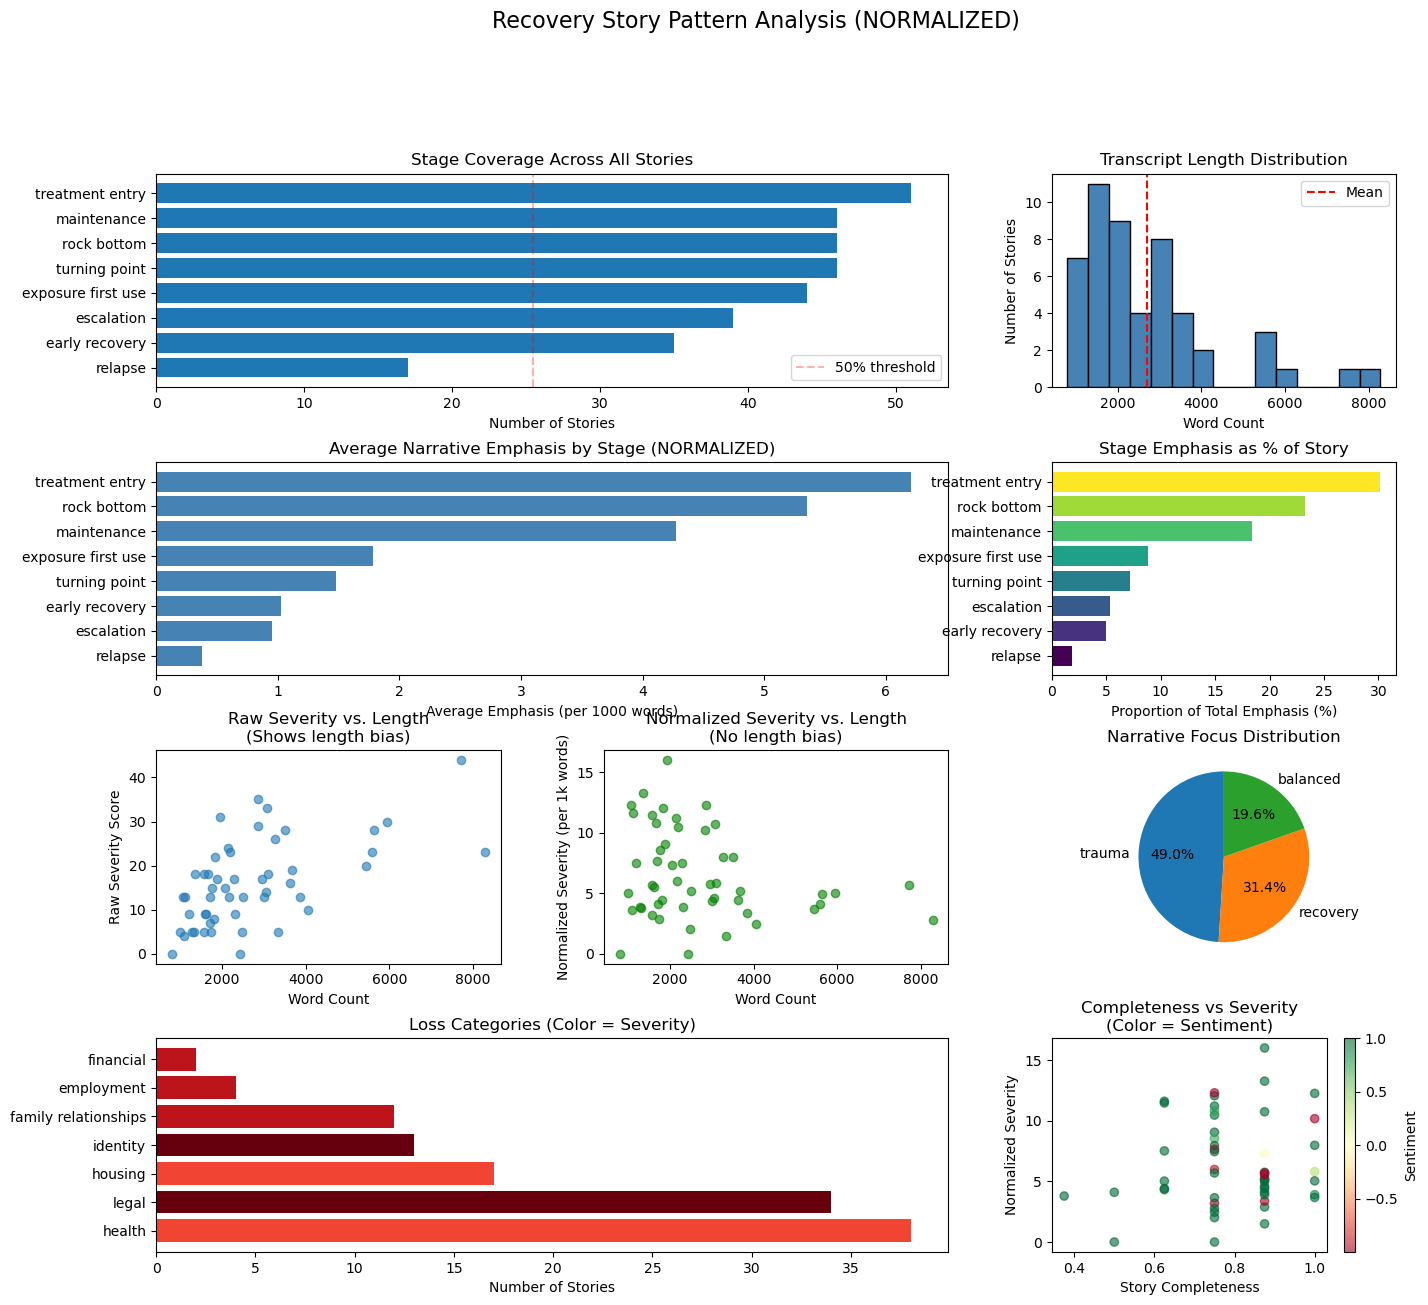

In [43]:
summary_df, loss_df, trauma_df, quotes_df, profiles = analyze_recovery_stories(df)
visualize_story_patterns(summary_df, loss_df)

In [ ]:
# This uses the data from Step 1
summary_df_final = run_all_analyses(summary_df, loss_df, trauma_df, quotes_df)


Top 10 by worstness_score:
      video_id  worstness_score  severity_normalized  rock_bottom_hits  \
0  _Zn66D2SQOo       101.368159             4.867759              47.0   
1  nhJskHOW05o        92.644803             8.642603              43.0   
2  te_KSAwmwQU        81.459457             5.459057              39.0   
3  tzA_jd1bJVA        76.665213             2.664813              38.0   
4  OSAKdvVf-5c        60.054022            10.017422              26.0   
5  avwelLFOUKk        55.695222             7.694422              13.0   
6  rf3yQhKwGJU        55.339321            11.836321              19.0   
7  ZMETz0qGAYw        54.752508            10.238908              23.0   
8  WkNbdTWlJVU        53.850501            11.850501              21.0   
9  cTgUyxT7M9s        53.706104             3.703704              26.0   

   relapse_hits  overall_sentiment  
0           3.0             0.9998  
1           0.0             0.9989  
2           0.0             0.9998  
3        

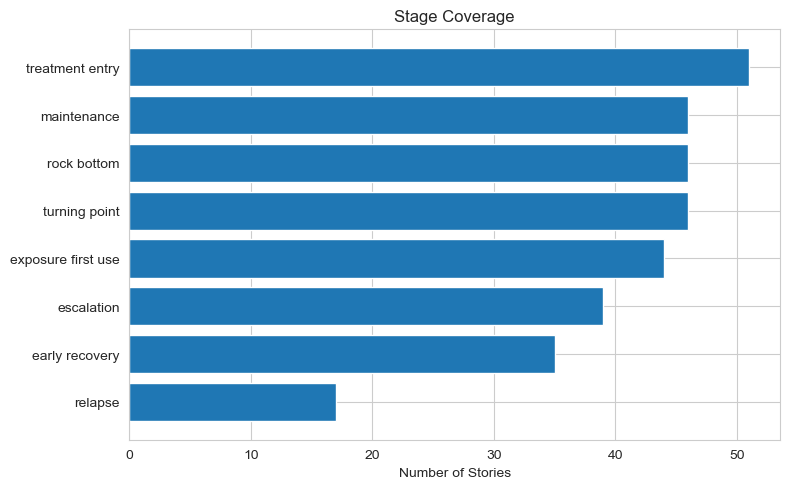

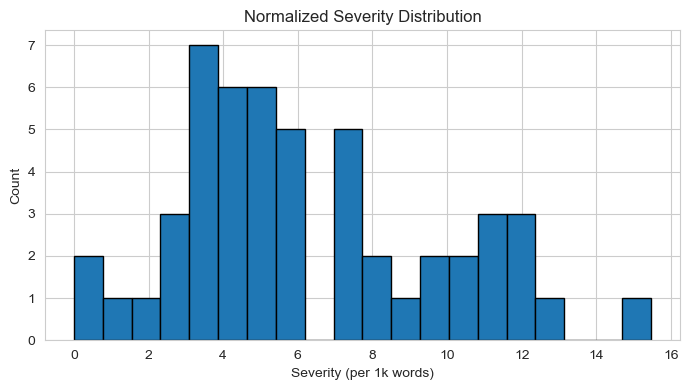

In [52]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==================== CONFIG ====================
FILE_PATH = "data\\playlist_transcripts_complete.csv"  # change if needed
USE_VADER = True          # set False to avoid nltk download
MIN_CHARS = 100           # skip super short transcripts
CHUNK_SENTS = 5           # sentences per chunk for sentiment curve

# ==================== SENTIMENT ====================
def setup_sentiment(use_vader=True):
    if not use_vader:
        return simple_sentiment
    try:
        import nltk
        from nltk.sentiment import SentimentIntensityAnalyzer
        try:
            nltk.data.find('vader_lexicon')
        except LookupError:
            nltk.download("vader_lexicon", quiet=True)
        sia = SentimentIntensityAnalyzer()
        return lambda text: sia.polarity_scores(str(text))["compound"]
    except Exception:
        return simple_sentiment

def simple_sentiment(text: str) -> float:
    neg = set(("bad worse worst painful ashamed guilty hopeless depressed anxious scared fear "
               "overdose od nearly died homeless lost arrested jail prison suicidal "
               "withdrawal craving relapse relapsed slipped sick broke debt bankrupt hate hated").split())
    pos = set(("good better best grateful peace purpose stable clean sober recovery recovered "
               "hope hopeful proud rebuild rebuilt thrive thriving").split())
    toks = re.findall(r"[a-z']+", str(text).lower())
    if not toks: return 0.0
    p = sum(t in pos for t in toks); n = sum(t in neg for t in toks)
    return (p - n) / max(1, (p + n))

sent = setup_sentiment(USE_VADER)

# ==================== RULESETS (from your snippet) ====================
STAGES = {
    "exposure_first_use": {
        "keywords": [
            "first time","first tried","started using","was prescribed","after surgery","injury",
            "doctor gave","curious","peer pressure","experimented","introduced to","pills","party"
        ],
        "weights": {"first time":3,"was prescribed":3,"after surgery":2}
    },
    "escalation": {
        "keywords": [
            "using daily","couldn't stop","tolerance","needed more","spiraled","lying","stealing",
            "lost control","hiding","double life","obsessed","chasing","every day","all the time"
        ],
        "weights": {"couldn't stop":3,"lost control":3,"spiraled":2}
    },
    "rock_bottom": {
        "keywords": [
            "rock bottom","hit bottom","overdose","od'd","nearly died","hospitalized","homeless",
            "lost everything","lost custody","arrested","jail","prison","suicidal","wanted to die",
            "lost job","lost family","nowhere to go"
        ],
        "weights": {"overdose":5,"nearly died":5,"rock bottom":4,"lost everything":4,"suicidal":4}
    },
    "turning_point": {
        "keywords": [
            "wake up call","woke up","turning point","realized","had to change","enough was enough",
            "asked for help","intervention","my kids","my child","my family","moment of clarity",
            "scared straight","second chance"
        ],
        "weights": {"turning point":4,"wake up call":4,"intervention":3}
    },
    "treatment_entry": {
        "keywords": [
            "detox","rehab","treatment","inpatient","outpatient","checked in","admitted",
            "12 step","aa","na","sponsor","therapist","counselor","mat",
            "suboxone","methadone","vivitrol","naltrexone"
        ],
        "weights": {"detox":3,"rehab":3,"treatment":2}
    },
    "early_recovery": {
        "keywords": [
            "withdrawal","detoxing","cravings","urges","triggers","daily meetings","90 in 90",
            "white knuckling","one day at a time","struggling","hard days","learning",
            "new routine","staying clean"
        ],
        "weights": {"withdrawal":3,"cravings":2,"one day at a time":2}
    },
    "relapse": {
        "keywords": [
            "relapsed","slipped","used again","went back out","picked up","fell off","back to using",
            "started using again"
        ],
        "weights": {"relapsed":4,"used again":3}
    },
    "maintenance": {
        "keywords": [
            "sober now","clean for","years sober","months clean","grateful","gratitude","giving back",
            "sponsoring","help others","peace","purpose","rebuilt","stable","found myself",
            "new life","thriving","recovery"
        ],
        "weights": {"years sober":4,"giving back":3,"grateful":2}
    }
}

LOSS_CATEGORIES = {
    "family_relationships": {
        "keywords": [
            "lost my family","lost custody","kids taken","divorce","left me","couldn't see my kids",
            "restraining order","family disowned","lost my wife","lost my husband"
        ],
        "severity": 5
    },
    "employment": {
        "keywords": ["lost my job","fired","couldn't work","career gone","lost everything i worked for","business failed"],
        "severity": 3
    },
    "housing": {
        "keywords": ["homeless","living on streets","lost my home","evicted","living in car","couch surfing","shelter"],
        "severity": 4
    },
    "legal": {
        "keywords": ["arrested","jail","prison","felony","probation","parole","court","charges","convicted"],
        "severity": 4
    },
    "health": {
        "keywords": ["overdose","od'd","hospitalized","nearly died","sick","hepatitis","hiv","infection","seizure"],
        "severity": 5
    },
    "financial": {
        "keywords": ["bankrupt","debt","lost savings","stole money","pawned","sold everything"],
        "severity": 3
    },
    "identity": {
        "keywords": ["lost myself","didn't know who i was","was not me","wasn't me","hated myself","soul"],
        "severity": 4
    }
}

# ==================== HELPERS ====================
def normalize_text(text: str) -> str:
    if not isinstance(text, str): return ""
    t = text.lower().strip()
    t = re.sub(r"\s+"," ",t)
    return t

def segment_text(text: str, chunk_sents: int = CHUNK_SENTS):
    sents = [s.strip() for s in re.split(r"(?<=[.!?])\s+", str(text)) if s.strip()]
    segs = []
    for i in range(0, len(sents), chunk_sents):
        seg = " ".join(sents[i:i+chunk_sents])
        if seg: segs.append(seg)
    return segs

def detect_stage_in_segment(segment: str, stage_name: str) -> tuple:
    low = segment.lower()
    info = STAGES[stage_name]
    score = 0.0
    matched = []
    for kw in info["keywords"]:
        if kw in low:
            score += info.get("weights", {}).get(kw, 1)
            matched.append(kw)
    # optional sentiment boost:
    if score > 0:
        s = sent(segment)
        if stage_name == "rock_bottom" and s < -0.3: score += 2
        if stage_name == "maintenance" and s > 0.3: score += 2
    return score, matched

def detect_losses(text: str) -> dict:
    low = text.lower()
    out = {}
    for cat, info in LOSS_CATEGORIES.items():
        matches = [kw for kw in info["keywords"] if kw in low]
        if matches:
            out[cat] = {"count": len(matches), "severity": info["severity"], "examples": matches[:3]}
    return out

def profile_story(transcript: str, video_id: str) -> dict:
    segs = segment_text(transcript, CHUNK_SENTS)
    wc = len(re.findall(r"\w+", transcript))
    stage_presence = {}
    stage_emphasis = {}
    stage_emphasis_norm = {}
    stage_prop = {}
    stage_segments = {}
    total_emph = 0.0

    for name in STAGES.keys():
        tot = 0.0
        best = ("", 0.0, [])
        for seg in segs:
            sc, kws = detect_stage_in_segment(seg, name)
            if sc > 0:
                tot += sc
                if sc > best[1]:
                    best = (seg, sc, kws)
        stage_presence[name] = tot > 0
        stage_emphasis[name] = tot
        total_emph += tot
        stage_emphasis_norm[name] = (tot / wc) * 1000 if wc > 0 else 0.0
        if best[1] > 0:
            stage_segments[f"{name}_best_quote"] = best[0]
            stage_segments[f"{name}_best_score"] = best[1]
            stage_segments[f"{name}_keywords"] = ", ".join(best[2])

    for name in STAGES.keys():
        stage_prop[name] = (stage_emphasis[name] / total_emph) if total_emph > 0 else 0.0

    losses = detect_losses(transcript)
    loss_raw = sum(v["severity"] * v["count"] for v in losses.values())
    sev_norm = (loss_raw / wc) * 1000 if wc > 0 else 0.0

    rock_hits = stage_emphasis.get("rock_bottom", 0.0)
    rel_hits = stage_emphasis.get("relapse", 0.0)
    overall = sent(transcript)

    worstness = sev_norm + 2*rock_hits + 1.5*rel_hits - 2*max(0, overall)

    return {
        "video_id": video_id,
        "word_count": wc,
        "overall_sentiment": overall,
        "severity_score": loss_raw,
        "severity_normalized": sev_norm,
        "rock_bottom_hits": rock_hits,
        "relapse_hits": rel_hits,
        "stage_presence": stage_presence,
        "stage_emphasis": stage_emphasis,
        "stage_emphasis_normalized": stage_emphasis_norm,
        "stage_emphasis_proportional": stage_prop,
        "stage_segments": stage_segments,
        "losses": losses,
        "worstness_score": worstness
    }

# ==================== PIPELINE ====================
def auto_columns(df: pd.DataFrame):
    text_cands = ["transcript_whisper","transcript","text","content","clean_text","body"]
    id_cands = ["video_id","id","videoid","title","name"]
    TEXT_COL = next((c for c in text_cands if c in df.columns), df.columns[0])
    ID_COL = next((c for c in id_cands if c in df.columns), "video_id")
    if ID_COL not in df.columns:
        df[ID_COL] = [f"video_{i}" for i in range(len(df))]
    return TEXT_COL, ID_COL

def run_analysis(path=FILE_PATH):
    df = pd.read_csv(path)
    TEXT_COL, ID_COL = auto_columns(df)

    profiles = []
    for idx, row in df.iterrows():
        tx = str(row[TEXT_COL])
        if len(tx) < MIN_CHARS: 
            continue
        vid = row.get(ID_COL, f"video_{idx}")
        profiles.append(profile_story(tx, vid))

    # ----- Build summary tables -----
    summary_rows, loss_rows, quote_rows = [], [], []
    for p in profiles:
        s = {
            "video_id": p["video_id"],
            "word_count": p["word_count"],
            "overall_sentiment": p["overall_sentiment"],
            "severity_score": p["severity_score"],
            "severity_normalized": p["severity_normalized"],
            "rock_bottom_hits": p["rock_bottom_hits"],
            "relapse_hits": p["relapse_hits"],
            "worstness_score": p["worstness_score"],
        }
        for st in STAGES.keys():
            s[f"has_{st}"] = p["stage_presence"][st]
            s[f"emphasis_norm_{st}"] = p["stage_emphasis_normalized"][st]
            s[f"emphasis_pct_{st}"] = p["stage_emphasis_proportional"][st]*100
        summary_rows.append(s)

        for loss_type, info in p["losses"].items():
            loss_rows.append({
                "video_id": p["video_id"],
                "loss_type": loss_type,
                "count": info["count"],
                "severity": info["severity"],
                "examples": ", ".join(info["examples"])
            })

        for st in STAGES.keys():
            qk = f"{st}_best_quote"
            if qk in p["stage_segments"]:
                quote_rows.append({
                    "video_id": p["video_id"],
                    "stage": st,
                    "score": p["stage_segments"].get(f"{st}_best_score", 0),
                    "keywords": p["stage_segments"].get(f"{st}_keywords",""),
                    "quote": p["stage_segments"][qk]
                })

    summary_df = pd.DataFrame(summary_rows).sort_values("worstness_score", ascending=False).reset_index(drop=True)
    loss_df = pd.DataFrame(loss_rows) if len(loss_rows) else pd.DataFrame(columns=["video_id","loss_type","count","severity","examples"])
    quotes_df = pd.DataFrame(quote_rows) if len(quote_rows) else pd.DataFrame(columns=["video_id","stage","score","keywords","quote"])

    # ----- Save -----
    summary_df.to_csv("recovery_summary.csv", index=False)
    loss_df.to_csv("recovery_losses.csv", index=False)
    quotes_df.to_csv("recovery_quotes.csv", index=False)

    # ----- Quick prints -----
    print("\nTop 10 by worstness_score:")
    print(summary_df[["video_id","worstness_score","severity_normalized","rock_bottom_hits","relapse_hits","overall_sentiment"]].head(10))

    # ----- Minimal visuals -----
    plt.figure(figsize=(8,5))
    stage_cols = [c for c in summary_df.columns if c.startswith("has_")]
    coverage = summary_df[stage_cols].sum().sort_values()
    names = [c.replace("has_","").replace("_"," ") for c in coverage.index]
    plt.barh(range(len(coverage)), coverage.values)
    plt.yticks(range(len(coverage)), names)
    plt.xlabel("Number of Stories")
    plt.title("Stage Coverage")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.hist(summary_df["severity_normalized"].values, bins=20, edgecolor="black")
    plt.xlabel("Severity (per 1k words)")
    plt.ylabel("Count")
    plt.title("Normalized Severity Distribution")
    plt.tight_layout()
    plt.show()

    return summary_df, loss_df, quotes_df

if __name__ == "__main__":
    summary_df, loss_df, quotes_df = run_analysis(FILE_PATH)
